# 多GPU训练
:label:`sec_multi_gpu`

到目前为止，我们讨论了如何在CPU和GPU上高效地训练模型。我们甚至在 :numref:`sec_auto_para` 中展示了深度学习框架如何使它们之间的计算和通信自动并行化。我们还在 :numref:`sec_use_gpu` 中展示了如何使用 `nvidia-smi` 命令列出计算机上所有可用的GPU。我们没有讨论的是如何真正实现深度学习训练的并行化。我们暗示了一种方法，即以某种方式将数据分割到多个设备上，并使其正常工作。本节将详细介绍如何从零开始并行训练网络。关于如何利用高级API中的详情请参阅 :numref:`sec_multi_gpu_concise` 。我们假设你熟悉小批量随机梯度下降算法，如  :numref:`sec_minibatch_sgd` 中描述的算法。

## 拆分问题

让我们从一个简单的计算机视觉问题和一个稍微旧点的网络开始，例如，有多个卷积层和池化层，最后可能有几个全连接的层。也就是说，让我们从一个看起来非常类似于 LeNet :cite:`LeCun.Bottou.Bengio.ea.1998`或AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`的网络开始。假设有多个GPU（如果是桌面服务器则为2个，AWS g4dn.12xlarge实例上为4个，p3.16xlarge上为8个，p2.16xlarge上为16个），我们希望以一种方式对训练进行拆分，以实现良好的加速比，同时受益于简单且可重复的设计选择。毕竟，多个GPU同时增加了内存和计算能力。简而言之，给出一小批量我们想要分类的训练数据，我们有以下选择。

首先，我们可以在多个GPU之间拆分网络。也就是说，每个GPU将流入特定层的数据作为输入，跨多个后续层处理数据，然后将数据发送到下一个GPU。与单个GPU所能处理的数据相比，这使我们可以用更大的网络处理数据。此外，每个GPU的显存占用可以得到很好的控制（它只是整个网络占用的一小部分）。

然而，层（以及GPU）之间的接口需要紧密同步。这可能很棘手，特别是在计算工作负载在层之间没有正确匹配的时候。对于大量的GPU来说，这个问题更加严重。层之间的接口还需要大量的数据传输，例如激活值和梯度。这可能会超出GPU总线的带宽。此外，计算密集型的操作顺序对于拆分来说是非常重要的。有关这方面的最佳努力，请参见 :cite:`Mirhoseini.Pham.Le.ea.2017` 。这仍然是一个困难的问题，目前还不清楚是否有可能在特定问题上实现良好的（线性）缩放。除非有优秀的框架或操作系统支持将多个GPU连接在一起，否则我们不建议使用它。

第二，我们可以拆分工作。例如，我们可以将问题分散到4个GPU，每个GPU生成16个通道的数据，而不是在单个GPU上计算64个通道。同样，对于全连接的层，我们可以拆分输出单元的数量。 :numref:`fig_alexnet_original` （来自 :cite:`Krizhevsky.Sutskever.Hinton.2012` ）说明了这种设计，这种策略用于显存非常小（当时为2GB）的GPU。这允许在计算方面进行良好的缩放，前提是通道（或单元）的数量不太小。此外，由于可用显存呈线性扩展，多个GPU可以处理越来越大的网络。

![由于GPU显存有限，原有AlexNet设计中存在模型并行性问题。](../img/alexnet-original.svg)
:label:`fig_alexnet_original`

但是，我们需要非常多的同步或阻塞操作，因为每一层都依赖于所有其他层的结果。此外，此外，需要传输的数据量可能比跨GPU拆分层时还要大。因此，由于其带宽成本和复杂性，我们不推荐这种方法。

最后，我们可以跨多个GPU对数据进行拆分。通过这种方式，所有GPU执行相同类型的工作，尽管观察结果不同。在每个小批量的训练数据之后，梯度在GPU上聚合。这是最简单的方法，可以应用于任何情况。我们只需要在每个小批处理之后进行同步。也就是说，当其他梯度参数仍在计算时，开始交换梯度参数是非常可取的。此外，GPU数量越多，小批量越大，从而提高了训练效率。但是，添加更多GPU并不能让我们训练更大的模型。

![在多个GPU上并行化。从左到右：原始问题、网络并行、分层并行、数据并行。](../img/splitting.svg)
:label:`fig_splitting`

:numref:`fig_splitting`中描述了多个GPU上不同并行方式的比较。总的来说，数据并行是最方便的方法，只要我们能访问有足够大显存的GPU。有关分布式训练并行的详细描述，请参见 :cite:`Li.Andersen.Park.ea.2014` 。GPU显存在深度学习的早期曾经是一个问题。到目前为止，除了最不寻常的情况外，这个问题已经解决了。下面我们将重点讨论数据并行性。

## 数据并行性

假设机器上有$k$个GPU。给定要训练的模型，每个GPU将独立地维护一组完整的模型参数，尽管GPU上的参数值是相同且同步的。例如， :numref:`fig_data_parallel` 演示了在$k=2$时使用数据并行的训练。

![利用两个GPU上的数据并行计算小批量随机梯度下降。](../img/data-parallel.svg)
:label:`fig_data_parallel`

一般来说，训练过程如下：

* 在训练的任何迭代中，给定一个随机的小批量，我们将该小批量中的样本分成$k$个部分，并将它们均匀地分在多个GPU上。
* 每个GPU根据分配给它的小批量子集计算模型参数的损失和梯度。
* 将$k$个GPU中每个GPU的局部梯度聚合以获得当前的小批量随机梯度。
* 聚合梯度被重新分配到每个GPU。
* 每个GPU使用这个小批量随机梯度来更新它维护的完整的模型参数集。

请注意，在实践中，当在$k$个GPU上训练时，我们将小批量大小增加$k$倍，这样每个GPU都有相同的工作量，就像我们只在单个GPU上训练一样。在16-GPU服务器上，这可以大大增加小批量大小，我们可能需要相应地提高学习速率。还请注意， :numref:`sec_batch_norm` 中的批量归一化需要调整，例如，为每个GPU保留单独的批量归一化参数。下面我们将使用一个简单网络来演示多GPU训练。


In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## [**简单网络**]

我们使用 :numref:`sec_lenet` 中介绍的LeNet（稍加修改）。我们从零开始定义它，从而详细说明参数交换和同步。


In [2]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

## 数据同步

对于高效的多GPU训练，我们需要两个基本操作。首先，我们需要有能力[**将参数分发给多个设备**]并附加梯度（`get_params`）。如果没有参数，就不可能在GPU上评估网络。第二，我们需要跨多个设备对参数求和的能力，也就是说，我们需要一个`allreduce`函数。


In [3]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

让我们通过将模型参数复制到一个GPU来尝试一下。


In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


由于我们还没有进行任何计算，偏置参数的梯度仍然为零。现在假设有一个向量分布在多个GPU上。下面的[**`allreduce`函数将所有向量相加，并将结果广播回所有GPU**]。请注意，要使其工作，我们需要将数据复制到累积结果的设备。


In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

让我们通过在不同设备上创建具有不同值的向量并聚合它们来测试这一点。


In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


## 分发数据

我们需要一个简单的实用函数来[**将一个小批量均匀地分布在多个GPU上**]。例如，在有两个GPU的时候，我们希望将一半的数据复制到其中一个GPU。因为深度学习框架中的内置函数更方便、更简洁，所以我们使用它在$4 \times 5$矩阵上进行了尝试。


In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


为了以后的复用，我们定义了一个`split_batch`函数，该函数同时拆分数据和标签。


In [8]:
#@save
def split_batch(X, y, devices):
    """将`X`和`y`拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices))

## 训练

现在我们可以[**在一个小批量上实现多GPU训练**]。它的实现主要基于本节描述的数据并行方法。我们将使用刚才讨论的辅助函数`allreduce`和`split_and_load`在多个GPU之间同步数据。注意，我们不需要编写任何特定的代码来实现并行性。由于计算图在小批量内的设备之间没有任何依赖关系，因此它是自动并行执行的。


In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [
        loss(lenet(X_shard, device_W),
             y_shard).sum() for X_shard, y_shard, device_W in zip(
                 X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])  # 在这里，我们使用全尺寸的小批量

现在，我们可以[**定义训练函数**]。它与前几章中使用的略有不同：我们需要分配GPU并将所有模型参数复制到所有设备。显然，每个小批量都是使用`train_batch`函数来处理多个GPU的。为了方便（和代码的简洁性），我们在一个GPU上计算精度，尽管这是低效的，因为其他GPU是空闲的。


In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到`num_gpus`个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU 0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

让我们看看这[**在单个GPU上运行**]得有多好。我们首先使用批量大小256，学习率为0.2。


In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

通过保持批量大小和学习率不变，并[**将GPU数增加到2个**]，我们可以看到测试精度与之前的实验基本相同。在优化算法方面，它们是相同的。不幸的是，这里没有任何有意义的加速：模型实在太小了；而且，我们只有一个很小的数据集，在这个数据集中，我们实现多GPU训练的简单方法受到了巨大的Python开销的影响。在未来，我们将遇到更复杂的模型和更复杂的并行化方法。尽管如此，让我们看看Fashion-MNIST会发生什么。


test acc: 0.80, 3.6 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


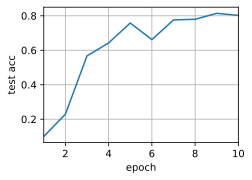

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 小结

* 有多种方法可以在多个GPU上拆分深度网络训练。我们可以在层之间、跨层或跨数据拆分它们。前两者需要经过严格编排的数据传输。数据并行是最简单的策略。
* 数据并行训练非常简单。但是，它增加了有效的小批量大小以提高效率。
* 在数据并行中，数据跨多个GPU拆分，其中每个GPU执行其自己的前向传播和反向传播，随后聚合梯度并将结果广播回GPU。
* 对于较大的小批量，我们可以使用稍微提高的学习率。

## 练习

1. 在$k$个GPU上进行训练时，将批量大小从$b$更改为$k \cdot b$，即按GPU的数量进行扩展。
1. 比较不同学习率的准确性。它如何随着GPU数量的增加而扩展？
1. 实现一个更高效的`allreduce`函数，在不同的GPU上聚合不同的参数？为什么效率更高？
1. 实现多GPU测试精度计算。


[Discussions](https://discuss.d2l.ai/t/2800)
